## Capstone Project - Winonsin Breast Cancer Diagnosis Deep Learning Revisited






#### Import necessary libraries

In [95]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit

from sklearn.preprocessing import MinMaxScaler

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

#### Load in WBCD dataset

In [96]:
# Load the Boston housing dataset
headers = ["ID","CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses","Diagnosis"]
data = pd.read_csv('breast-cancer-wisconsin.csv', names = headers)
data = data.reset_index(drop=True)

#### Handle missing data

In [97]:
data = data.replace('?', np.nan)
data = data.fillna(0)

#### Define a data generation function with random noise

In [98]:
def generateData(data):
    # make a copy of data
    data2 = data

    diagnosis2 = data2['Diagnosis']
    features2 = data2.drop(['ID','Diagnosis'], axis = 1)
    features2_headers = ["CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses"]

    mu, sigma = 0, 0.1 
    # creating a noise with the same dimension as the dataset 
    noise = np.random.normal(mu, sigma, features2.shape) 

    features2 = features2.apply(pd.to_numeric, errors='ignore')

    features2_with_noise = features2.add(pd.DataFrame(noise, columns = features2_headers), fill_value=0)

    data2 = pd.concat([features2_with_noise, pd.DataFrame(diagnosis2)], axis = 1)
    
    return data2

#### Add the new generated dataset into the existing dataset

In [99]:
new_data = generateData(data)
data = data.append(new_data, ignore_index=True)

new_data = generateData(data)
data = data.append(new_data, ignore_index=True)

print("data size = ", data.size)

('data size = ', 30756)


#### Scale dataset to the range of [0, 1]

In [100]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ["Diagnosis","CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses"]
data[numerical] = scaler.fit_transform(data[numerical])

#### Separate Labels/Classes from Features

In [101]:
diagnosis = data['Diagnosis']
features = data.drop(['ID','Diagnosis'], axis = 1)

In [102]:
# features_means = features.sum() / features.shape[0]
# features_centered = features - features_means
# features_deviations = features.std(axis=0)   # Get column standard deviations
# features_centered_and_scaled = features_centered / features_deviations 

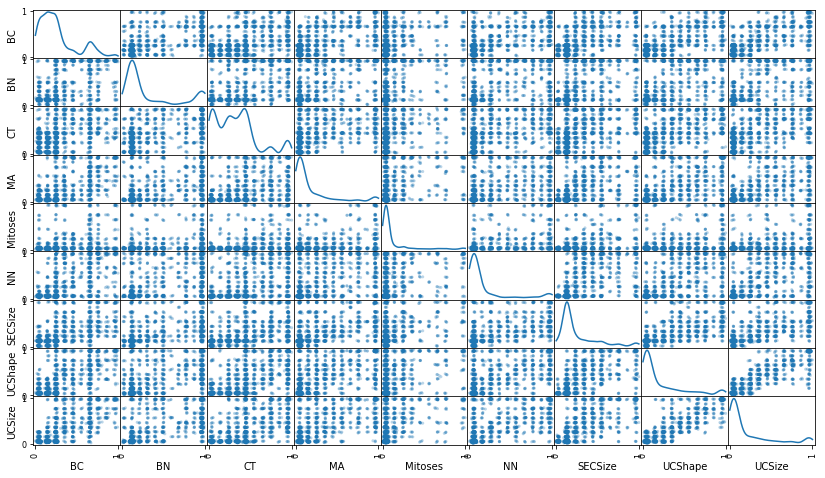

In [103]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(features, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

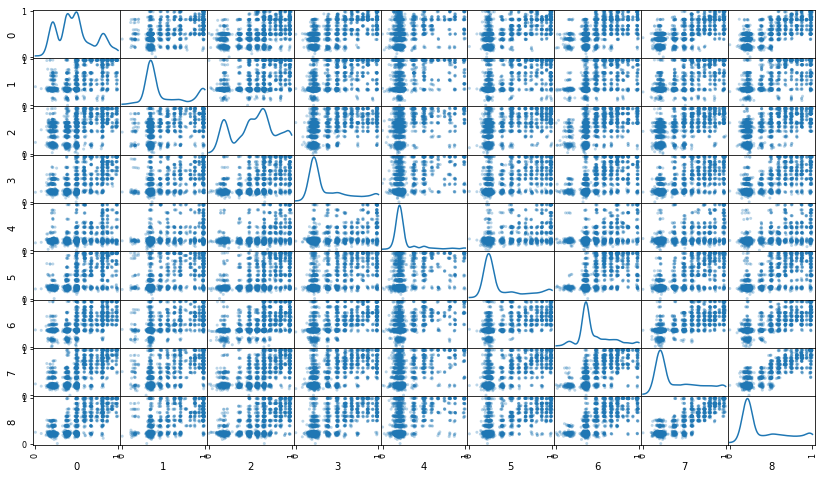

In [104]:
# Scale the data using the natural logarithm
log_features = features.copy()

for feature_name in log_features.columns:
    log_features[feature_name] = np.sqrt(log_features[feature_name]) # np.log(log_features[feature_name])
    
log_features = log_features.replace([np.inf, -np.inf], np.nan)
log_features = log_features.fillna(0)

log_features = scaler.fit_transform(log_features)

# Produce a scatter matrix for each pair of newly-transformed features
pd.plotting.scatter_matrix(pd.DataFrame(log_features), alpha = 0.3, figsize = (14,8), diagonal = 'kde');

# convert numpy ndarray into Pandas DataFrame
features = pd.DataFrame(log_features)

#### Split dataset into training and testing datasets

In [105]:
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, diagnosis, test_size=0.25, random_state=42)

#### Reindex 

In [106]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#### Convert Pandas DataFrame to Numpy ndarray

In [107]:
X_train = X_train.values
y_train = y_train.values
X_test  = X_test.values
y_test  = y_test.values

#### Classify dataset using Random Forest Classifier

In [108]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=2, random_state=0)
rfc.fit(X_train, y_train)
# y_predict = rfc.predict(X_test)

score = rfc.score(X_test, y_test)
print("score = ", score)

('score = ', 0.96995708154506433)


#### Deep learning

In [109]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
import keras
import keras.utils
from keras import utils as np_utils

#### Define NN Architecture

In [110]:
model = Sequential()

#Define your architecture.
model.add(Dense(9, activation='relu', input_dim=9))
model.add(Dropout(0.5))
model.add(Dense(5, activation='relu', input_shape=(9,)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='relu', input_shape=(5,)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 9)                 90        
_________________________________________________________________
dropout_9 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 50        
_________________________________________________________________
dropout_10 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 6         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 2         
Total params: 148
Trainable params: 148
Non-trainable params: 0
_________________________________________________________________


#### Compile NN Model

In [111]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

#### Train NN Model

In [112]:
model.fit(X_train, y_train, epochs=400, batch_size=10)

Epoch 1/400
2097/2097 [==============================] - 0s - loss: 0.6804 - acc: 0.6419     
Epoch 2/400
2097/2097 [==============================] - 0s - loss: 0.6048 - acc: 0.7787     
Epoch 3/400
2097/2097 [==============================] - 0s - loss: 0.5520 - acc: 0.8093     
Epoch 4/400
2097/2097 [==============================] - 0s - loss: 0.5164 - acc: 0.8326     
Epoch 5/400
2097/2097 [==============================] - 0s - loss: 0.4791 - acc: 0.8374     
Epoch 6/400
2097/2097 [==============================] - 0s - loss: 0.4511 - acc: 0.8517     
Epoch 7/400
2097/2097 [==============================] - 0s - loss: 0.4314 - acc: 0.8588     
Epoch 8/400
2097/2097 [==============================] - 0s - loss: 0.4293 - acc: 0.8555     
Epoch 9/400
2097/2097 [==============================] - 0s - loss: 0.3772 - acc: 0.8817     
Epoch 10/400
2097/2097 [==============================] - 0s - loss: 0.3727 - acc: 0.8832     
Epoch 11/400
2097/2097 [==============================] - 0

2097/2097 [==============================] - 0s - loss: 0.2604 - acc: 0.9366     
Epoch 88/400
2097/2097 [==============================] - 0s - loss: 0.2528 - acc: 0.9347     
Epoch 89/400
2097/2097 [==============================] - 0s - loss: 0.2582 - acc: 0.9270     
Epoch 90/400
2097/2097 [==============================] - 0s - loss: 0.2615 - acc: 0.9323     
Epoch 91/400
2097/2097 [==============================] - 0s - loss: 0.2712 - acc: 0.9337     
Epoch 92/400
2097/2097 [==============================] - 0s - loss: 0.2499 - acc: 0.9380     
Epoch 93/400
2097/2097 [==============================] - 0s - loss: 0.2799 - acc: 0.9289     
Epoch 94/400
2097/2097 [==============================] - 0s - loss: 0.2530 - acc: 0.9371     
Epoch 95/400
2097/2097 [==============================] - 0s - loss: 0.2634 - acc: 0.9318     
Epoch 96/400
2097/2097 [==============================] - 0s - loss: 0.2376 - acc: 0.9428     
Epoch 97/400
2097/2097 [==============================] - 0s - 

2097/2097 [==============================] - 0s - loss: 0.2379 - acc: 0.9442     
Epoch 173/400
2097/2097 [==============================] - 0s - loss: 0.2062 - acc: 0.9499     
Epoch 174/400
2097/2097 [==============================] - 0s - loss: 0.2725 - acc: 0.9380     
Epoch 175/400
2097/2097 [==============================] - 0s - loss: 0.2628 - acc: 0.9390     
Epoch 176/400
2097/2097 [==============================] - 0s - loss: 0.2518 - acc: 0.9380     
Epoch 177/400
2097/2097 [==============================] - 0s - loss: 0.2456 - acc: 0.9371     
Epoch 178/400
2097/2097 [==============================] - 0s - loss: 0.2671 - acc: 0.9351     
Epoch 179/400
2097/2097 [==============================] - 0s - loss: 0.2549 - acc: 0.9356     
Epoch 180/400
2097/2097 [==============================] - 0s - loss: 0.2307 - acc: 0.9447     
Epoch 181/400
2097/2097 [==============================] - 0s - loss: 0.2514 - acc: 0.9409     
Epoch 182/400
2097/2097 [=============================

2097/2097 [==============================] - 0s - loss: 0.2788 - acc: 0.9356     
Epoch 258/400
2097/2097 [==============================] - 0s - loss: 0.2678 - acc: 0.9356     
Epoch 259/400
2097/2097 [==============================] - 0s - loss: 0.2588 - acc: 0.9380     
Epoch 260/400
2097/2097 [==============================] - 0s - loss: 0.2473 - acc: 0.9447     
Epoch 261/400
2097/2097 [==============================] - 0s - loss: 0.2777 - acc: 0.9385     
Epoch 262/400
2097/2097 [==============================] - 0s - loss: 0.2344 - acc: 0.9347     
Epoch 263/400
2097/2097 [==============================] - 0s - loss: 0.2562 - acc: 0.9361     
Epoch 264/400
2097/2097 [==============================] - 0s - loss: 0.2365 - acc: 0.9409     
Epoch 265/400
2097/2097 [==============================] - 0s - loss: 0.2571 - acc: 0.9394     
Epoch 266/400
2097/2097 [==============================] - 0s - loss: 0.2642 - acc: 0.9356     
Epoch 267/400
2097/2097 [=============================

2097/2097 [==============================] - 0s - loss: 0.2612 - acc: 0.9289     
Epoch 343/400
2097/2097 [==============================] - 0s - loss: 0.2607 - acc: 0.9337     
Epoch 344/400
2097/2097 [==============================] - 0s - loss: 0.2502 - acc: 0.9404     
Epoch 345/400
2097/2097 [==============================] - 0s - loss: 0.2354 - acc: 0.9380     
Epoch 346/400
2097/2097 [==============================] - 0s - loss: 0.2704 - acc: 0.9356     
Epoch 347/400
2097/2097 [==============================] - 0s - loss: 0.2586 - acc: 0.9380     
Epoch 348/400
2097/2097 [==============================] - 0s - loss: 0.2551 - acc: 0.9309     
Epoch 349/400
2097/2097 [==============================] - 0s - loss: 0.2597 - acc: 0.9356     
Epoch 350/400
2097/2097 [==============================] - 0s - loss: 0.2348 - acc: 0.9394     
Epoch 351/400
2097/2097 [==============================] - 0s - loss: 0.2575 - acc: 0.9361     
Epoch 352/400
2097/2097 [=============================

#### Test NN Model

In [113]:
score = model.evaluate(X_test, y_test, batch_size=10)
print("score = ", score)

699/699 [==============================] - 0s     
('score = ', [0.17689718829417264, 0.97281830624619947])
